## 1. Data Preparation

### 1.1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV , KFold
from sklearn.metrics import mean_squared_error 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge , ElasticNet , Lasso
from sklearn.ensemble import RandomForestRegressor  , AdaBoostRegressor 

- Import data, check for comlumns and variables
### 1.2. Load and Clean Data
Load the dataset, inspect its structure, and perform initial cleaning. We drop the original 'Price' column (in Toman) and use 'Price(USD)' for our analysis, renaming it to 'Price'.

In [2]:
houses = pd.read_csv("./data/housePrice.csv")
houses = houses.drop('Price', axis=1)
houses = houses.rename(columns={'Price(USD)': 'Price'})
houses.info()
houses.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       3479 non-null   object 
 1   Room       3479 non-null   int64  
 2   Parking    3479 non-null   bool   
 3   Warehouse  3479 non-null   bool   
 4   Elevator   3479 non-null   bool   
 5   Address    3456 non-null   object 
 6   Price      3479 non-null   float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 119.0+ KB


,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,63,1,True,True,True,Shahran,61666.67
1,60,1,True,True,True,Shahran,61666.67
2,79,2,True,True,True,Pardis,18333.33
3,95,2,True,True,True,Shahrake Qods,30083.33
4,123,2,True,True,True,Shahrake Gharb,233333.33


- Since the Address column has some missing data in certain rows, we will drop these rows.

In [3]:
houses = houses.dropna(subset=['Address'])

- Check the header again

In [4]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3456 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       3456 non-null   object 
 1   Room       3456 non-null   int64  
 2   Parking    3456 non-null   bool   
 3   Warehouse  3456 non-null   bool   
 4   Elevator   3456 non-null   bool   
 5   Address    3456 non-null   object 
 6   Price      3456 non-null   float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 145.1+ KB


- That said, the data is now complete. HOWEVER, we have not yet categorized the data into the two main types: Numerical and Categorical. Now, we will do that.

In [5]:
# Convert specified columns to categorical data type
houses['Room'] = houses['Room'].astype('category')
houses['Parking'] = houses['Parking'].astype('category')
houses['Warehouse'] = houses['Warehouse'].astype('category')
houses['Elevator'] = houses['Elevator'].astype('category')

# Fix 'Area' datatype
houses['Area'] = pd.to_numeric(houses['Area'], errors='coerce')
houses = houses.dropna(subset=['Area'])
# Verify the changes
print("Data types after conversion:")
print(houses.dtypes)
houses.info()

Data types after conversion:
Area          float64
Room         category
Parking      category
Warehouse    category
Elevator     category
Address        object
Price         float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 3450 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Area       3450 non-null   float64 
 1   Room       3450 non-null   category
 2   Parking    3450 non-null   category
 3   Warehouse  3450 non-null   category
 4   Elevator   3450 non-null   category
 5   Address    3450 non-null   object  
 6   Price      3450 non-null   float64 
dtypes: category(4), float64(2), object(1)
memory usage: 121.7+ KB


### 1.3. Outlier Removal
To prevent extreme values from skewing the analysis, we remove the top and bottom 1% of properties based on price.

In [6]:
# Calculate 1st and 99th percentiles
lower_percentile = houses['Price'].quantile(0.01)
upper_percentile = houses['Price'].quantile(0.99)

print(f"1st percentile (1% lowest): ${lower_percentile:.2f}")
print(f"99th percentile (1% highest): ${upper_percentile:.2f}")

# Remove outliers
houses_before = len(houses)
houses = houses[(houses['Price'] >= lower_percentile) & (houses['Price'] <= upper_percentile)]
houses_after = len(houses)

print(f"\nDataset size before removing outliers: {houses_before}")
print(f"Dataset size after removing outliers: {houses_after}")
print(f"Removed {houses_before - houses_after} outliers ({((houses_before - houses_after) / houses_before * 100):.1f}%)")

1st percentile (1% lowest): $9833.33
99th percentile (1% highest): $1333333.33

Dataset size before removing outliers: 3450
Dataset size after removing outliers: 3389
Removed 61 outliers (1.8%)


In [7]:
# Check for duplicated values in the houses dataset
duplicated_values = houses[houses.duplicated()]
print(f'The Number of Duplicated values : {len(duplicated_values)}')
print(f'The Percentage of Duplicated values : {round(len(duplicated_values) / len(houses) * 100)}%')

# Remove duplicates and reset index
houses.drop_duplicates(inplace=True)
houses.reset_index(inplace=True)
houses.drop('index', axis=1, inplace=True)
houses.head()
houses.info()

The Number of Duplicated values : 204
The Percentage of Duplicated values : 6%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3185 entries, 0 to 3184
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Area       3185 non-null   float64 
 1   Room       3185 non-null   category
 2   Parking    3185 non-null   category
 3   Warehouse  3185 non-null   category
 4   Elevator   3185 non-null   category
 5   Address    3185 non-null   object  
 6   Price      3185 non-null   float64 
dtypes: category(4), float64(2), object(1)
memory usage: 87.7+ KB


## 2. Feature Engineering & Data Preprocessing

- Convert the True/False values in the amenities to 0/1.

In [8]:
# Convert True/False values to 1/0 for utility features
houses['Parking'] = houses['Parking'].astype(int)
houses['Warehouse'] = houses['Warehouse'].astype(int)
houses['Elevator'] = houses['Elevator'].astype(int)

    # Display the updated dataframe
houses.tail()

,Area,Room,Parking,Warehouse,Elevator,Address,Price
3180,63.0,1,1,1,0,Feiz Garden,63000.00
3181,86.0,2,1,1,1,Southern Janatabad,116666.67
3182,83.0,2,1,1,1,Niavaran,226666.67
3183,105.0,2,1,1,1,Dorous,186666.67
3184,82.0,2,0,1,1,Parand,12000.00


In [9]:
# Create categorical features using get_dummies for Address, Area_Group, and Price_Group
categorical_features = pd.get_dummies(houses[["Address"]])
houses = houses.merge(categorical_features, left_index=True, right_index=True)
houses.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Address_Abazar,Address_Abbasabad,Address_Absard,...,Address_Waterfall,Address_West Ferdows Boulevard,Address_West Pars,Address_Yaftabad,Address_Yakhchiabad,Address_Yousef Abad,Address_Zafar,Address_Zaferanieh,Address_Zargandeh,Address_Zibadasht
0,63.0,1,1,1,1,Shahran,61666.67,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,60.0,1,1,1,1,Shahran,61666.67,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,79.0,2,1,1,1,Pardis,18333.33,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,95.0,2,1,1,1,Shahrake Qods,30083.33,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,123.0,2,1,1,1,Shahrake Gharb,233333.33,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
prepared_dataset = houses.drop(["Address"], axis=1)
prepared_dataset.head()

,Area,Room,Parking,Warehouse,Elevator,Price,Address_Abazar,Address_Abbasabad,Address_Absard,Address_Abuzar,...,Address_Waterfall,Address_West Ferdows Boulevard,Address_West Pars,Address_Yaftabad,Address_Yakhchiabad,Address_Yousef Abad,Address_Zafar,Address_Zaferanieh,Address_Zargandeh,Address_Zibadasht
0,63.0,1,1,1,1,61666.67,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,60.0,1,1,1,1,61666.67,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,79.0,2,1,1,1,18333.33,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,95.0,2,1,1,1,30083.33,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,123.0,2,1,1,1,233333.33,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## 3. Model training

- Create the x-axis as all features except Price, and the y-axis as Price.

In [11]:
X = prepared_dataset.drop(["Price"],axis=1)
y = prepared_dataset["Price"]
X_train , X_test , y_train , y_test  = train_test_split(X , y , test_size=.3 , random_state=0)

- Train shape

In [12]:
print("X Train and Test shape:")
print(f'X_train : {X_train.shape}')
print(f'X_test  : {X_test.shape}')
print("---" * 30)
print("y Train and Test shape:")
print(f'y_train : {y_train.shape}')
print(f'y_test  : {y_test.shape}')
print("---" * 30)

# Also print the feature count and sample count
print("Dataset Summary:")
print(f"Total samples: {len(X_train) + len(X_test)}")
print(f"Training samples: {len(X_train)} ({len(X_train)/(len(X_train) + len(X_test)):.2%})")
print(f"Testing samples: {len(X_test)} ({len(X_test)/(len(X_train) + len(X_test)):.2%})")
print(f"Number of features: {X_train.shape[1]}")

X Train and Test shape:
X_train : (2229, 195)
X_test  : (956, 195)
------------------------------------------------------------------------------------------
y Train and Test shape:
y_train : (2229,)
y_test  : (956,)
------------------------------------------------------------------------------------------
Dataset Summary:
Total samples: 3185
Training samples: 2229 (69.98%)
Testing samples: 956 (30.02%)
Number of features: 195


- Save the index and performance of each type of model on the dataset.

In [13]:
Model_Name  = []
Train_Score = []
Test_Score  = []
MSE_Score   = []
RMSE_Score  = []
Time_Score  = []

In [14]:
def model_prediction(model):
    
    start_time = time.time()
    model.fit(X_train, y_train)
    y_prediction = model.predict(X_test)
    TrainScore = model.score(X_train, y_train)
    TestScore = model.score(X_test, y_test)
    MSEscore = mean_squared_error(y_test, y_prediction)
    RMSEscore = np.sqrt(MSEscore)
    end_time = time.time()
    Timescore = end_time - start_time
    
    Name = str(model).split('(')[0]
    Model_Name.append(Name)
    Train_Score.append(TrainScore)
    Test_Score.append(TestScore)
    MSE_Score.append(MSEscore)
    RMSE_Score.append(RMSEscore)
    Time_Score.append(Timescore)

    print(f'Model: {Name}')
    print('=' * 50)
    print(f'Training R² Score: {TrainScore:.4f} ({TrainScore*100:.2f}%)')
    print(f'Testing R² Score:  {TestScore:.4f} ({TestScore*100:.2f}%)')
    print('=' * 50)
    print(f'Mean Squared Error:  ${MSEscore:,.0f}')
    print(f'Root Mean Squared Error: ${RMSEscore:,.0f}')
    print('=' * 50)
    print(f'Training Time: {Timescore:.3f} seconds')
    print('\n')


1.  Regression Model

In [15]:
model_prediction(ElasticNet())

Model: ElasticNet
Training R² Score: 0.4731 (47.31%)
Testing R² Score:  0.4237 (42.37%)
Mean Squared Error:  $21,006,590,758
Root Mean Squared Error: $144,937
Training Time: 0.057 seconds




In [16]:
model_prediction(Lasso())

Model: Lasso
Training R² Score: 0.7760 (77.60%)
Testing R² Score:  0.7127 (71.27%)
Mean Squared Error:  $10,473,039,864
Root Mean Squared Error: $102,338
Training Time: 0.834 seconds




c:\Users\ducho\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.868e+10, tolerance: 8.789e+09
  model = cd_fast.enet_coordinate_descent(


In [17]:
model_prediction(Ridge())

Model: Ridge
Training R² Score: 0.7691 (76.91%)
Testing R² Score:  0.7184 (71.84%)
Mean Squared Error:  $10,264,731,823
Root Mean Squared Error: $101,315
Training Time: 0.060 seconds




In [18]:
model_prediction(LinearRegression())
model_prediction(KNeighborsRegressor())
model_prediction(DecisionTreeRegressor())
model_prediction(RandomForestRegressor())
model_prediction(AdaBoostRegressor())

Model: LinearRegression
Training R² Score: 0.7760 (77.60%)
Testing R² Score:  0.7120 (71.20%)
Mean Squared Error:  $10,498,922,389
Root Mean Squared Error: $102,464
Training Time: 0.063 seconds


Model: KNeighborsRegressor
Training R² Score: 0.7833 (78.33%)
Testing R² Score:  0.6964 (69.64%)
Mean Squared Error:  $11,068,534,718
Root Mean Squared Error: $105,207
Training Time: 0.411 seconds


Model: DecisionTreeRegressor
Training R² Score: 0.9846 (98.46%)
Testing R² Score:  0.7822 (78.22%)
Mean Squared Error:  $7,939,493,156
Root Mean Squared Error: $89,104
Training Time: 0.072 seconds


Model: RandomForestRegressor
Training R² Score: 0.9614 (96.14%)
Testing R² Score:  0.8448 (84.48%)
Mean Squared Error:  $5,659,426,305
Root Mean Squared Error: $75,229
Training Time: 2.073 seconds


Model: AdaBoostRegressor
Training R² Score: 0.4551 (45.51%)
Testing R² Score:  0.3996 (39.96%)
Mean Squared Error:  $21,886,897,126
Root Mean Squared Error: $147,942
Training Time: 0.796 seconds




c:\Users\ducho\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


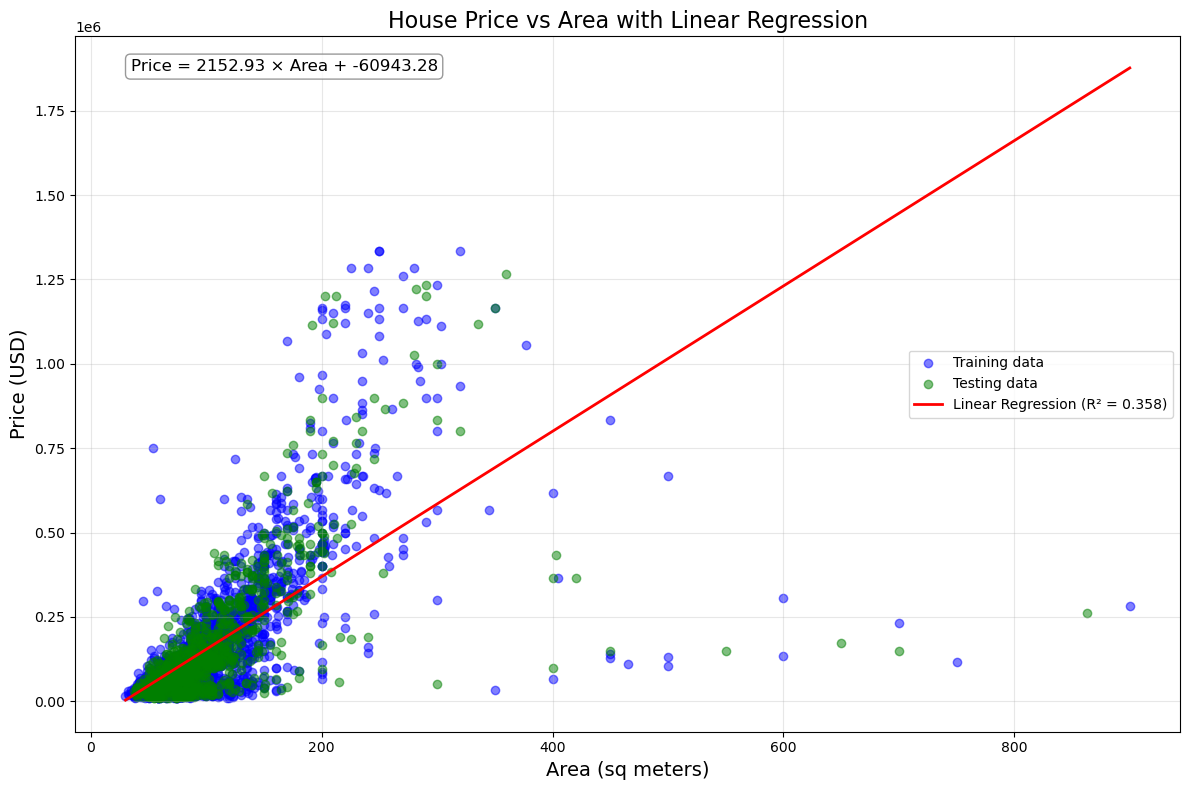

In [19]:
# Create a scatter plot of Area vs Price with regression line
plt.figure(figsize=(12, 8))

# Scatter plot of training data
plt.scatter(X_train['Area'], y_train, alpha=0.5, color='blue', label='Training data')

# Scatter plot of testing data
plt.scatter(X_test['Area'], y_test, alpha=0.5, color='green', label='Testing data')

# Fit a simple linear regression line
lr_model = LinearRegression()
lr_model.fit(X_train[['Area']], y_train)
x_range = np.linspace(min(X_train['Area']), max(X_train['Area']), 100)
y_pred = lr_model.predict(x_range.reshape(-1, 1))

# Plot regression line
plt.plot(x_range, y_pred, color='red', linewidth=2, label=f'Linear Regression (R² = {lr_model.score(X_test[["Area"]], y_test):.3f})')

# Add labels and title
plt.title('House Price vs Area with Linear Regression', fontsize=16)
plt.xlabel('Area (sq meters)', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Annotate coefficient
coef = lr_model.coef_[0]
intercept = lr_model.intercept_
plt.annotate(f'Price = {coef:.2f} × Area + {intercept:.2f}', 
             xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

In [20]:
# Calculate R-squared (coefficient of determination) for test data
test_r_squared = lr_model.score(X_test[['Area']], y_test)

# Calculate predictions
y_test_pred = lr_model.predict(X_test[['Area']])

# Calculate MSE and RMSE
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

# Calculate explained variance
explained_variance = test_r_squared * 100

print("Linear Regression Model Performance:")
print(f"R² (Coefficient of Determination): {test_r_squared:.4f}")
print(f"Explained Variance: {explained_variance:.2f}%")
print(f"Mean Squared Error (MSE): ${test_mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): ${test_rmse:,.2f}")
print(f"Model Equation: Price = {coef:.2f} × Area + {intercept:.2f}")

Linear Regression Model Performance:
R² (Coefficient of Determination): 0.3583
Explained Variance: 35.83%
Mean Squared Error (MSE): $23,392,007,920.00
Root Mean Squared Error (RMSE): $152,944.46
Model Equation: Price = 2152.93 × Area + -60943.28
